In [104]:
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

torch.manual_seed(2530622);

### Part 1. On attention [2 points]

Answer each question in max. 3 lines. Points will be subtracted for long answers so be short and precise. Add your explanations in the below box - NO added handwritten images, write in latex!

1. [0.5 point] You are given an input $X=[x_1,...,x_L]$ (e.g. a sentence of tokenised words). Your goal is to predict the next token $x_i$ conditional on $x_{1},...,x_{i}$. In other words, the $i$-th position can only be influenced by a position $j$ if and only if $j \leq i$, namely a position cannot be influenced by the subsequent positions.

    a. What would be the problem when passing $X$ through attention? Explain using the computations that attention performs, e.g. you can write out the matrix multiplication.
    
    b. How could you ensure that the prediction for position $i$ depends solely on positions $j\leq i$? Hint: what in the attention computation should be masked & in what way?

2. [0.5 point] Let's consider multi-head attention. How does multi-head attention change the computations inside the softmax (the $QK^T$ term) and the product with $V$ and why could this be beneficial to learning?
3. [0.5 point] Remember that standard attention is given by
\begin{align}
Q = XW^Q, \; K=XW^K, \; V=XW^V, \;\; \textnormal{with} A(X) = softmax\left(\frac{QK^T}{\sqrt{D}}\right)V
\end{align}
for a sequence $X\in\mathbb{R}^{L\times D}$ with $L$ the sequence length.
What is the memory and computational cost of attention in terms of the sequence length and where does this come from?
4. [0.5 point] A big focus these days is on making attention more computationally efficient. The $i$-th row (as a vector) of attention can be rewritten as,
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L sim(Q_i,K_j)V_j}{\sum_{j=1}^L sim(Q_i,K_j)},
\end{align}
with $sim(q,k)=exp(q^Tk/\sqrt{D})$.
Linear attention would be given by,
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L \phi(Q_i)^T\phi(K_j)V_j}{\sum_{j=1}^L\phi(Q_i)^T\phi(K_j)}.
\end{align}
Explain the relation between regular attentin and linear attention (i.e. what kind of similarity function does linear attention assume and how is the approximation made?) & how the above expression can be rewritten and use this to explain why linear attention computation can be done more efficiently compared to standard attention.

Fill in your answers below.

1. (a) In the attention formule we have softmax over the $L \times L$ matrix :
$$
(QK^T)_{nm} = Q_{n \alpha} K_{m \alpha} = (XW^Q)_{n \alpha} (XW^K)_{m \alpha} = (X_{n \beta} W^Q_{\alpha \beta}) (X_{m \gamma} W^K_{\alpha \gamma}) \; .
$$
We can see that in each row (corresponds to token) $i=n$, all of the other tokens $m \le L$ are taken into account. Moreover, $softmax$ of one row/column by definition mixes up all elements *nonlineary*, so each resulting element $i$ depends on all of the tokens $L$.  
(b) Mask the matrix input to the $softmax$. For row $i$, set all of the elements $z_{ij}$ after the diagonal with $j>i, \; \; z_{ij} = (QK^T)_{ij} = -\infty$. The $softmax$ denominator becomes $∑^L_k e^{z_{ik}}=0 + ∑^L_{k \le i} e^{z_{ik}}$ and the matrix is upper-triangular. Thus, each row $i$ truncates after the diagonal, and the $V$ multiplication keeps each row's information to depend only on tokens $x_j \; \; j \le i$.  


2. Within each head $i$, the attention formula is essentialy unchanged only that the weights are $W^K_i, W^Q_i, W^V_i$. Only for practical matters, we first concatenate the matrices (along dim. $D_k$) and then multiply on, e.g. $X \; cat((W^K_i)_i)$. Multiheads' purpose is to have diversety in attention computation so that the model could learn multiple distinct features of the data, like multiple filters in convolution. UNSURE ABOUT THE CAT PART CHECK IT

3. From [1], the time complexity of the first matrix multiplication is $O(L^2 D)$, $softmax$ has exponentiation and division of elements, and summations of rows, which is max $O(L^2)$, finally the last $V$ multiplication is $O(L^2 D)$. In total, time-complexity as a function of $L$ is $O(L^2)$. Memory complexity is $O_M(L^2)$, because the largest $L$-order in structure size appears in $QK^T$, which is a $L \times L$ matrix.

4. In regular attention $sim(Q_i, K_j)=e^{Q_i^T K_j/\sqrt{D}}$ and in linear attention $sim(Q_i, K_j)=\phi(Q_i)^T\phi(K_j)$ which is a (vector) dot-product. Using matrix associativity we can rewrite
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L \phi(Q_i)^T\phi(K_j)V_j}{\sum_{j=1}^L\phi(Q_i)^T\phi(K_j)} = \frac{\phi(Q_i)^T \sum_{j=1}^L \phi(K_j)V_j^T}{ \phi(Q_i)^T \sum_{j=1}^L\phi(K_j)} .
\end{align}
Hence, time complexity is $O(L)$, as the dot product $\phi(K_j)V_j^T$ is on $d_k$ length vectors, the only contribution is $L$ summation.  
ADD ANSWER TO HOW THE APPROXIMATION IS MADE IN 4!!




### Part 2. On diffusion models [12 points]

We will be implementing a diffusion model. We will follow mostly the setup as done here: https://arxiv.org/pdf/2006.11239.pdf so please refer to this work for more details if needed.

Your goal will be to implement the code for the diffusion model, find the right configuration to train the model, achieve good accuracy and efficiency and finally interpret how the model learns. You will be marked on clean code, concise answers and good results.

We will be working with the FashionMNIST dataset. You can load the data using the below code.

In [105]:
IMG_SIZE = 28
BATCH_SIZE = 128

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
channels = 1

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])


# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

dataloader = DataLoader(transformed_dataset['train'], batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

The following helper functions will be useful. In particular, whenever we input a vector (list) of values, this will help to select the right time t output. We will use this in the sampling loops.

In [14]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def plot_iteration_grid(imgs, stepsize, img_names=None, title=""):
    """
    Display a batch of images sequences.

    :param imgs: A list of tensors. Essentialy an nxm matrix, each row is m iterations of the same image. Each entry
     in imgs is a tensor of size [batch_size, 3, H, W].
    :param stepsize: Stepsize on iterations.
    :param img_names: List of length batch_size with names for the sequences.
    :param title: title (optional).
    """
    row_length = (len(imgs) // stepsize)
    fig, axes = plt.subplots(imgs[0].shape[0], row_length, figsize=(15, 8))
    fig.suptitle(title, y=0.9)

    if img_names is None:
        img_names = ["" for _ in range(imgs[0].shape[0])]

    if imgs[0].shape[0] == 1:
        axes = [axes]

    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            ax.imshow(imgs[j][i][0].cpu().detach().numpy())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

            if not i:
                ax.set_title(f"iteration {j * stepsize}")

            if not j:
                ax.set_ylabel(f"{img_names[i]}")

    fig.tight_layout()
    plt.show()


##### 1. The noising process [2 points]

[1.5 pts] Our first step will be to implement the forward process that adds noise to an image.

We will be adding noise according to a linear schedule, i.e. the noises $\beta_t$, $t=1,...,T$ will come from an equally spaced vector. Implement the `linear_beta_schedule` function. Remember $\alpha_t = 1-\beta_t$ and $\bar \alpha_t = \prod_{s=1}^t \alpha_s$.

Remember that we have the closed-form solutions for the image at time $t$. Use those in the implementation of `forward_diffusion_sample` instead of a for loop over each noising step. This means you will need to implement `sqrt_one_minus_alphas_cumprod` which represents $\sqrt{1-\bar\alpha_t}$ and `sqrt_alphas_cumprod` which represents $\sqrt{\bar\alpha_t}$.

Test the function on an image from the dataset using the given code below.

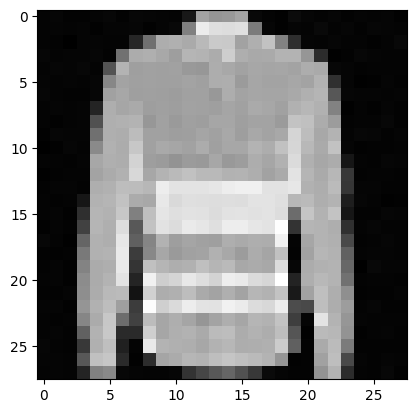

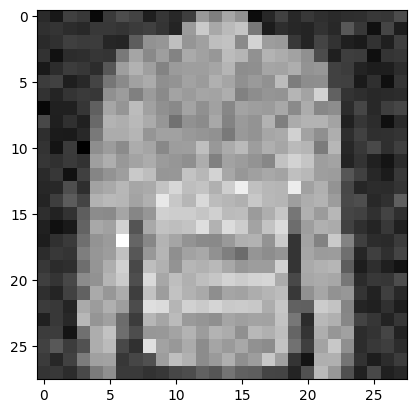

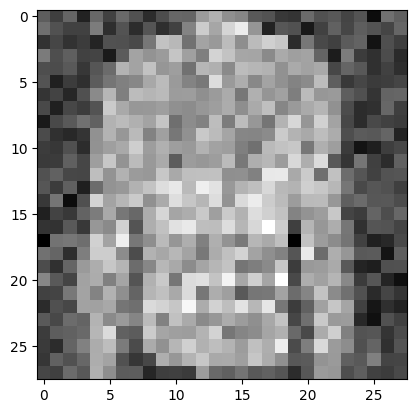

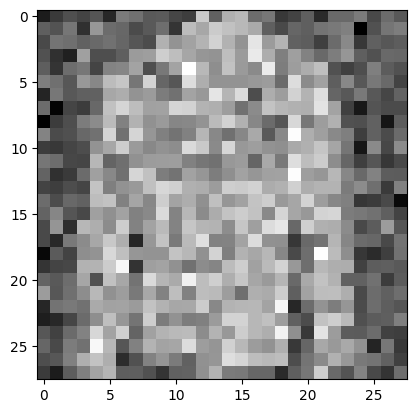

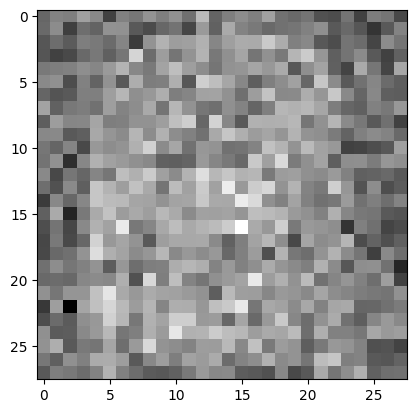

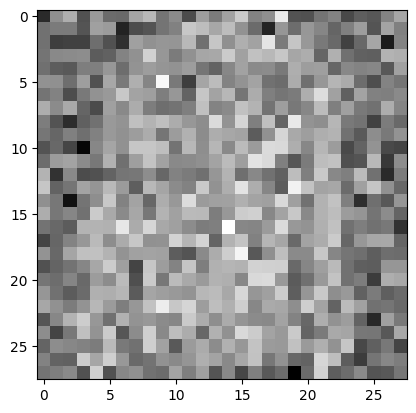

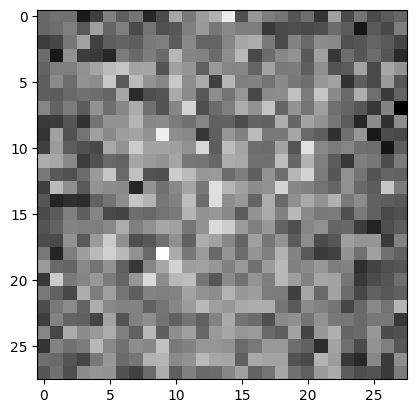

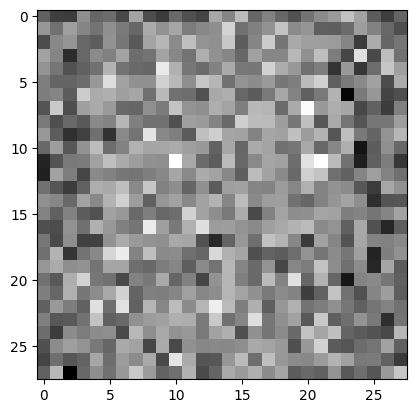

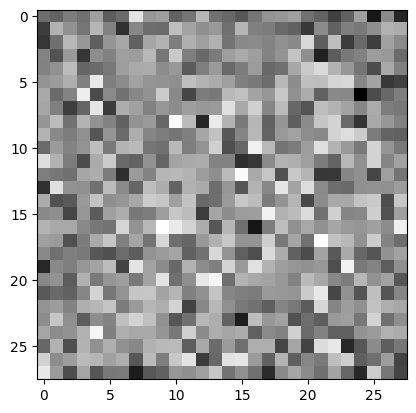

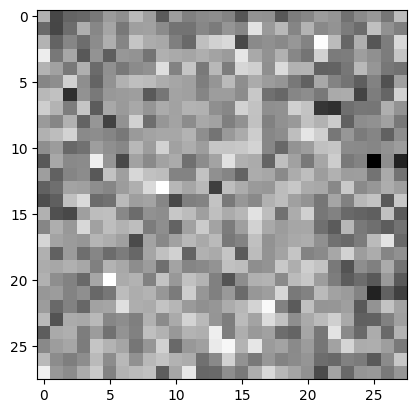

In [51]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    '''
    output a vector of size timesteps that is equally spaced between start and end; this will be the noise that is added in each time step.
    '''
    return torch.linspace(start, end, timesteps)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    Hint: use the get_index_from_list function to select the right values at time t.
    """
    pure_noise = torch.randn_like(x_0, dtype=torch.float64)
    scaled_noise = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape) * pure_noise
    xt = torch.clamp(get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape) * x_0, -1., 1.)

    return xt + scaled_noise, pure_noise

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
# ADD HERE THE COMPUTATIONS NEEDED for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0)
sqrt_alphas_cumprod = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_bar)

# Simulate forward diffusion
batch = next(iter(dataloader))["pixel_values"]
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    plt.imshow(img.reshape(28, 28), cmap="gray")
    plt.show()

[0.5 pt] Play around with the noise (compare two different beta schedules), present results for the two settings and discuss (in max. 3 lines) how the hyperparameters change the forward sampling.

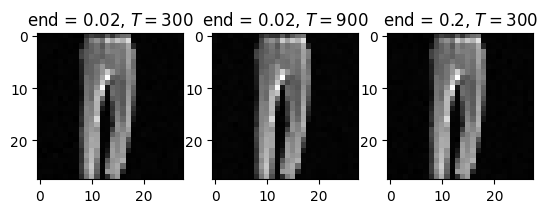

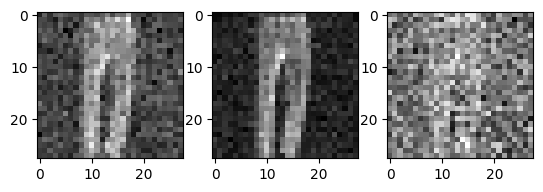

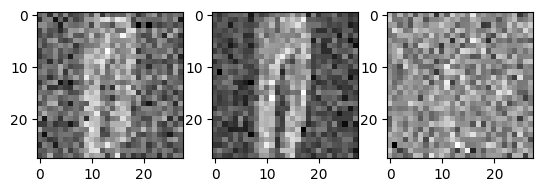

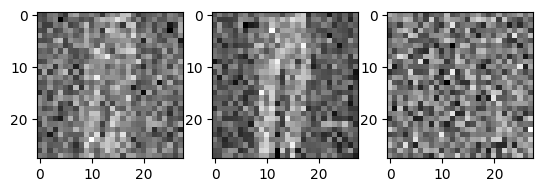

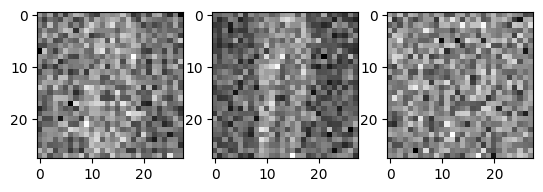

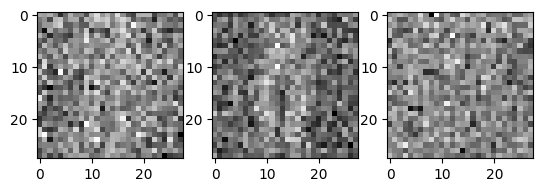

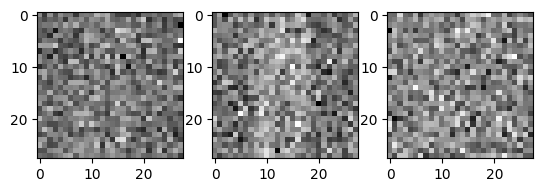

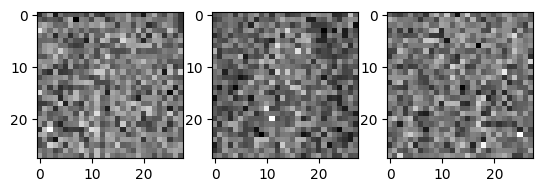

In [85]:
T = 300
betas1 = linear_beta_schedule(end=0.02, timesteps=T)
betas2 = linear_beta_schedule(end=0.02, timesteps=3*T)
betas3 = linear_beta_schedule(end=0.2, timesteps=T)

# Pre-calculate different terms for closed form
alphas1 = 1 - betas1
alphas_bar1 = torch.cumprod(alphas1, 0)
sqrt_alphas_cumprod1 = torch.sqrt(alphas_bar1)
sqrt_one_minus_alphas_cumprod1 = torch.sqrt(1 - alphas_bar1)

alphas2 = 1 - betas2
alphas_bar2 = torch.cumprod(alphas2, 0)
sqrt_alphas_cumprod2 = torch.sqrt(alphas_bar2)
sqrt_one_minus_alphas_cumprod2 = torch.sqrt(1 - alphas_bar2)

alphas3 = 1 - betas3
alphas_bar3 = torch.cumprod(alphas3, 0)
sqrt_alphas_cumprod3 = torch.sqrt(alphas_bar3)
sqrt_one_minus_alphas_cumprod3 = torch.sqrt(1 - alphas_bar3)

# Simulate forward diffusion
batch = next(iter(dataloader))["pixel_values"]
num_images = 7
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    img1, _ = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod1, sqrt_one_minus_alphas_cumprod1)
    img2, _ = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod2, sqrt_one_minus_alphas_cumprod2)
    img3, _ = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod3, sqrt_one_minus_alphas_cumprod3)
    
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(img1.reshape(28, 28), cmap="gray")
    axes[1].imshow(img2.reshape(28, 28), cmap="gray")
    axes[2].imshow(img3.reshape(28, 28), cmap="gray")

    if not idx:
        axes[0].set_title(f"end = 0.02, $T={T}$")
        axes[1].set_title(f"end = 0.02, $T={3*T}$")
        axes[2].set_title(f"end = 0.2, $T={T}$")
    
    plt.show()

**Discussion - Forward hyperparameters**  
According to [2], at each step $t$, we sample from $\mathcal{N}(\sqrt{1-\beta_t} x_{t-1}, \beta_t I)$ given $x_{t-1}$. For $\beta_t \approx 1$, $\sqrt{1-\beta_t} \approx 0$, resulting in pure noise. As shown in the figure above, with increasing timesteps $T$, the equidistant $\beta_t$ decrease, leading to less noise added at each step. Comparing columns 2 and 1, $T=600$ has more timesteps than $T=300$, thus each step in the former has less noise (smaller $\beta_t$). Increasing `end` instead of $T$ (column 3) results in wider steps $\beta_t$, leading to bigger noise addition.

##### 2. The model for the noise [4 points]

We use a simple form of a UNet to predict the noise in the image. The input into the neural network will be a noisy image and the ouput from the model will be the noise in the image. It is important to also pass in the timestep into the neural network (so the model knows at which time we want to denoise the image) and we do this by passing it through a sinusoidal position embedding.

[0.5pt] Write code for the Sinusoidal Position Embedding. This should output a matrix $PE$ of size `[timesteps, dimension]` with elements:

\begin{align}
&PE_{pos,2i} = \sin\left(\frac{pos}{10000^{2i/dim}}\right),\\
&PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{2i/dim}}\right),
\end{align}
where `pos` refers to the time position and `i` refers to the dimension position and `dim` the total dimension we are working with.

Use however the following identity to implement:
\begin{align}
\frac{pos}{10000^{2i/dim}} = \exp\left(\log(pos) - \frac{2i}{dim}\log(10000)\right).
\end{align}

[0.5pt] Visualise the positional embeddings with arbitary time and dimension and discuss what position embeddings do (why do we add them, why this particular embedding structure) in max. 3 lines.

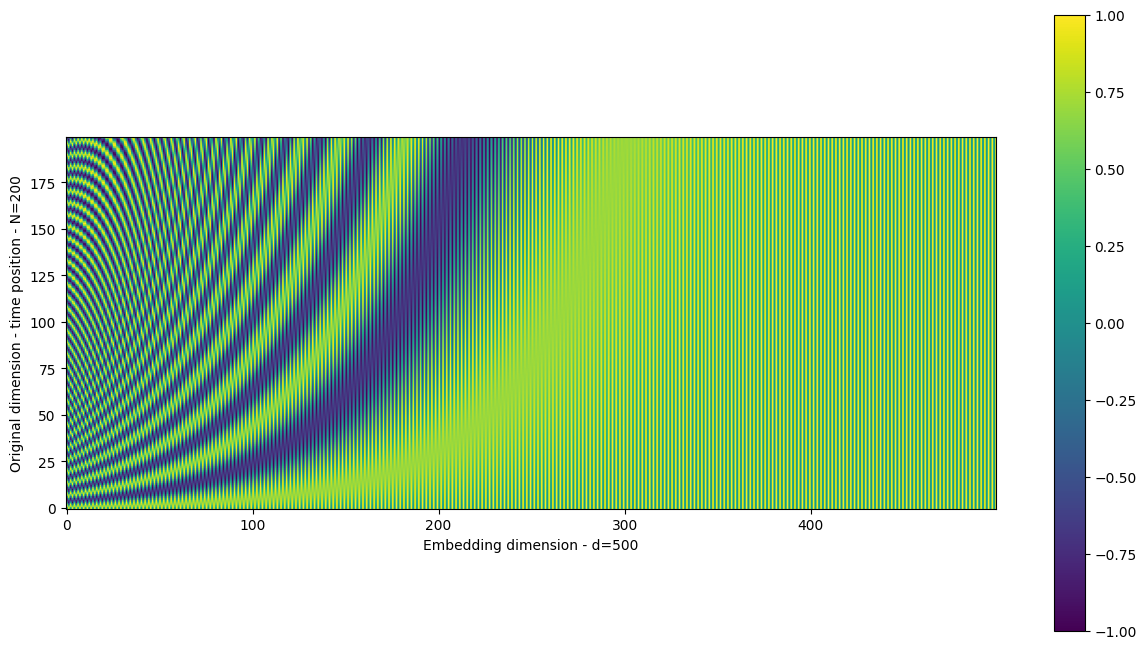

In [87]:
class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim, device):
        super().__init__()
        self.dim = dim
        self.device = device

    def forward(self, time):
        res = torch.zeros((len(time), self.dim), dtype=torch.float32, device=self.device)

        pos = torch.arange(len(time)).unsqueeze(1)
        two_i = torch.arange(0, self.dim, 2)

        arg = torch.exp(-two_i * torch.log(torch.tensor(10 ** 4)) / self.dim)

        res[:, 0::2] = torch.sin(pos * arg)
        res[:, 1::2] = torch.cos(pos * arg)

        return res


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d = 500
N = 200
embed = SinusoidalPositionEmbeddings(d, device)
res = embed(torch.linspace(0.001, 1, N))

plt.figure(figsize=(15, 8))
plt.imshow(res.cpu().numpy())
plt.xlabel(f"Embedding dimension - d={d}")
plt.ylabel(f"Original dimension - time position - N={N}")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

**Discussion - Positional Embbeding**  
Models like attention and diffusion handle time-series data as input, (e.g. tokenized sentence), but their architecture lacks the positional information. Positional embedding fixes that by injecting positional information. The sine/cosine structure is beneficial for its normalized output ($[-1, 1]$), smooth functions, unique sinusoid assignment (unique frequency) for each position [3], and ability to capture local and global behaviour (local changes for small $d$, and global for big $d$, as seen above).


Below is the code for a Block, that will make up the final UNet.

[0.5pt] Fill in the missing parts.

Remember that in the UNet architecture, we have a downsampling phase and an upsampling phase. Depending on which phase we are in, we need to make use of the up or down-sample operations.

[0.5pt] Add here an explanation as to what the block does including the up and downsample operations in maximum 3 lines:

**Discussion - UNet Block**  
The UNet architecture aims to learn various features of the input on different scales. In each level (scale), the Downsample block reduces the spatial dimensions of the input while increasing the channels, i.e. it "converts" spatial information into features in a latent space. The Upsample block increase spatial resolution and reduce channels (using transposed convolution or interpolation), thus it recovers finer details and features from the high-channel latent space. 

In [88]:
IMG_SIZE = 28
BATCH_SIZE = 128


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False, bottom=False, dropout=0.1):
        """
        in_ch refers to the number of channels in the input to the operation and out_ch how many should be in the output
        """
        super().__init__()

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            kernel, padding = (4, 2) if bottom else (3, 1)

            self.transform = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(out_ch, out_ch, kernel, padding=padding),
            )
            # self.transform = nn.ConvTranspose2d(out_ch, out_ch, 2, 2, output_padding=output_padding)  # changed params so ker==stride

        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(dropout)

    def forward(self, x, t):
        """
        Define the forward pass making use of the components above.
        Time t should get mapped through the time_mlp layer + a relu
        The input x should get mapped through a convolutional layer with relu / batchnorm
        The time embedding should get added the output from the input convolution
        A second convolution should be applied and finally passed through the self.transform.
        """
        t = self.relu(self.time_mlp(t))
        x = self.relu(self.conv1(x))
        x = self.bnorm1(x)
        # x = self.dropout(x)

        x = x + t[:, :, None, None]
        x = self.relu(self.conv2(x))
        x = self.bnorm2(x)

        return self.transform(x)


[1.5pt] Use the above code to fill in the code for the UNet below.

In [ ]:

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self, base_channels, device):
        super().__init__()

        #: The 'depth' of the unet, i.e. the amount of down blocks and up blocks.
        #: It has to be below 3 to avoid various problems with image size H,W (e.g. H,W shrinks to 1,1 which is too
        #: small to kernel size, or unmatching H,W between same-level up and down blocks)
        self.depth = 3
        #: Device
        self.device = device

        image_channels = 1
        down_channels = [base_channels * (2 ** i) for i in range(self.depth + 1)]
        up_channels = [(base_channels * 2 ** (self.depth - i)) for i in range(self.depth + 1)]
        out_dim = image_channels
        time_emb_dim = 32

        self.relu = nn.ReLU()

        #: Sinusoidal time embedding
        self.time_embed = SinusoidalPositionEmbeddings(time_emb_dim, device)
        self.lin_time = nn.Linear(time_emb_dim, time_emb_dim, device)

        #: Initial projection to down_channels[0]
        self.project_up = nn.Conv2d(image_channels, down_channels[0], (3, 3), padding=(1, 1))

        # Downsample and upsample
        down = []
        for i in range(self.depth):
            down.append(Block(down_channels[i], down_channels[i + 1], time_emb_dim))

        up = []
        for i in range(self.depth):
            # out_pad = 1 if i == 0 else 0
            bottom = (i == 0)
            up.append(Block(up_channels[i], up_channels[i + 1], time_emb_dim, True, bottom))

        self.down = nn.ModuleList(down)
        self.up = nn.ModuleList(up)

        #: Final output: a final convolution that maps up_channels[-1] to out_dim with a kernel of size 1.
        self.project_down = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.relu(self.lin_time(self.time_embed(timestep)))
        # Initial conv
        x = self.project_up(x)

        residuals = []
        for i in range(self.depth):
            x = self.down[i](x, t)
            residuals.append(x)

        for i in range(self.depth):
            x = torch.concat((x, residuals.pop()), 1)
            x = self.up[i](x, t)

        return self.project_down(x)


[0.5pt] Finally, define a loss function. Note that this loss function should take x_0 and t to sample the forward diffusion model, get a noisy image, use this noisy image in the model to get the noise added and finally compare true added noise and model outputs added noise.

In [89]:
def get_loss(model, x_0, t):
    '''
    See Diffusion class' method 'get_loss' below
    '''
    pass

##### Part 3: The sampling [1 point]

Write a piece of code that can be used to predict the noise and return the denoised image. This function should work on a single image and make sure that the function can be used in the `sample` function properly. Note that we will need the `posterior_variance` denoted by $\sigma$ in the paper and the `sqrt_recip_alphas` given by $1/\alpha_t$. Make sure to set the right choice of $\sigma$ (see the paper).

In [90]:
# compute posterior_variance
posterior_variance = 0 # FILL IN WITH THE RIGHT SETUP;
sqrt_recip_alphas = 0 # FILL IN WITH THE RIGHT SETUP;

@torch.no_grad()
def sample_timestep(x, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, sqrt_alphas_cumprod):
    """
    See Diffusion class' method 'sample_timestep' below
    """
    pass

@torch.no_grad()
def sample(model, shape):
    """
    See Diffusion class' method 'sample' below
    """
    pass
    

##### Part 4. Write the training loop and present & interpret your results [6 points]

Code a training loop that instantiates the model, defines an optimiser, defines a number of epochs, iterates over the epochs and the datapoints inside the epoch and for each iteration samples a timestep, uses this timestep to loss function and update parameters based on this.

Note: this is the part requiring most computational resources. You may need to train the model for quite a few epochs to get good results. Be sure to start on time to ensure enough access to GPUs on Google Colab.

0.5 point will be given for correct implementation.

1.5 points will be given according to how many **sensible** samples (with max points given for 10 good samples; scaled accordingly for less samples) you manage to obtain (i.e. the performance of your model in generating good datapoints).

2 points will be given according to how efficient you can make the train process to still produce at least 10 good samples. You are free to change anything in the architecture! Your output will be compared to my base setup which uses `50` epochs and has a model with `Num params:  929409`. 1 point will be assigned scaled according to how much less epochs you can use and 1 points scaled with how much less params you manage to use. Be sure to print your number of parameters, training epochs and the 10 sensible images.

2 points will be given for the interpretation of your results that allows us to better understand *how* the model learns. For this you are asked to visualise the generated samples during the training process. Can you identify any properties of *how* the model learns? Are there particular aspects the model starts paying attention to / is able to generate before others?

In [91]:
class Diffusion():
    def __init__(self, T: int, base_channels, device, cosine=False):
        self.unet = SimpleUnet(base_channels, device).to(device=device)
        self.T = T
        self.device = device

        if cosine:
            alpha_bar = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
            betas = []
            for i in range(T):
                t1 = i / T
                t2 = (i + 1) / T
                betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), 0.999))

            self.beta = torch.tensor(betas).to(device=device)

        else:
            #: A list of T equidistant points between 0.0001 and 0.02
            self.beta = torch.linspace(0.0001, 0.02, T, device=device)

        #: A list of T equidistant points compliment to self.beta
        self.alpha = 1 - self.beta

        #: A list of T alpha_bar values. Each entry is cumprod of alphas up to time t
        self.alpha_bar = torch.cumprod(self.alpha, 0)
        #: Precalculating values
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        alpha_bar_prev = torch.cat((torch.tensor([1.]).to(device=device), self.alpha_bar[:-1]), 0)
        self.posterior_variance = self.beta * (1 - alpha_bar_prev) / (1 - self.alpha_bar)

    def forward_diffusion_sample(self, x_0: torch.Tensor, t: torch.Tensor):
        """
        Forward diffusion process, i.e. take an image or batch of images and return the images at timestep t, which
        a certain amount of noise determined by t.
        :param x_0: torch.Tensor of clean datapoint images in batch of shape [batch_size, 1, 28, 28]
        :param t: torch.Tensor of values ranging from 0 to T with shape [batch_size]
        :param device: Device
        :return: torch.Tensor with shape as x_0 but with noise determined by t.
        """
        if x_0.shape[0] != t.shape[0]:
            raise ValueError("x_0 and t must have same shape[0] which is batch_size")

        pure_noise = torch.randn_like(x_0, dtype=torch.float32, device=self.device)
        scaled_noise = get_index_from_list(self.sqrt_one_minus_alpha_bar, t, x_0.shape) * pure_noise
        xt = torch.clamp(get_index_from_list(self.sqrt_alpha_bar, t, x_0.shape) * x_0, -1., 1.)

        return xt + scaled_noise, pure_noise

    def get_loss(self, x_0, t):
        """
        Loss per batch (x_0, t).
        Sample forward diffusion, get noisy image, get noise from unet, compare noise from unet to image noise.

        :param x_0: torch.Tensor of clean datapoint images in batch of shape [batch_size, 1, 28, 28]
        :param t: torch.Tensor of values ranging from 0 to T with shape [batch_size]
        :return: MSE loss between the noise and model's prediction of noise, reduced over batch.
        """
        if x_0.shape[0] != t.shape[0]:
            raise ValueError("x_0 and t must have same shape[0] which is batch_size")

        xt, noise = self.forward_diffusion_sample(x_0, t)

        return nn.functional.mse_loss(noise, self.unet(xt, t))

    @torch.no_grad()
    def sample_timestep(self, xt, t, i):
        """
        Calls the model to predict the noise in the image based on t and returns the denoised image.
        Applies noise to this image, if we are not in the last step yet.

        :param xt: torch.Tensor of a *single* noisy image, shape [28, 28]
        :param t: torch.Tensor the timestep of the noisy image
        :param i: no idea
        :return:
        """
        if xt.shape[0] != t.shape[0] and xt.shape[0] != 1:
            raise ValueError("xt and t must have same shape[0] which is 1")

        beta = get_index_from_list(self.beta, t, xt.shape)
        sqrt_alpha_recip = torch.sqrt(1/(1-beta))
        sqrt_one_minus_alpha_bar = get_index_from_list(self.sqrt_one_minus_alpha_bar, t, xt.shape)
        posterior_variance = get_index_from_list(self.posterior_variance, t, xt.shape) * torch.sqrt(self.beta[i])

        mean = sqrt_alpha_recip * (xt - (beta/sqrt_one_minus_alpha_bar) * self.unet(xt, t))
        if i == 0:
            return mean

        return mean + torch.sqrt(posterior_variance) * torch.randn(xt.shape, device=xt.device)

    @torch.no_grad()
    def sample(self, shape):
        batch_size = shape[0]
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=self.device)
        imgs = []
        for i in tqdm(reversed(range(0, self.T)), desc='Sampling loop time step', total=self.T):
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)
            img = self.sample_timestep(img, t, i)
            imgs.append(img.cpu().numpy())

        return imgs


Finally, after training is done, use the `sample` to sample new images.

In [ ]:
# Code for the plotting of samples goes here

Include your best generated samples below.

In [ ]:
# Code to show the best samples goes here

Include your most efficient implementation details below.

In [ ]:
# Code to make your most efficient setup goes here; present all code from above in one Code block
# run it to show final runtimes and print out the total number of parameters in the mode.

Interpretation of your results goes here.

In [ ]:
# Here goes the code for visualising during training and add a discussion above.

### Part 3. On DeepDream [5 points]

In this task we will implement a DeepDream model in order to generate ‘dreams’: images enhanced by the neural network.

Here we will work with a pre-trained model (Inception-V3). The idea is as follows: we will load some image (you can later on choose to load your own image if you want). We will load the Inception-V3 model. We will pass it an input and obtain the activation outputs from a certain layer. We will 'ask' the neural network to maximise the values of the activation, i.e. enhance the image with what those layer activations 'like' to see. For this we will implement a gradient ascent method in order to maximise a norm of the activations over that input. This will change our input into a `dream'.

1. [1 point] Write a piece of code that will load the Inception-V3 model and allow you to get access to the intermediate activations.

2. [2 points] Implement the deepdream optimisation loop. We will use gradient ascent to optimise for the norm of the activation. Implement a function that performs this gradient ascent. This function will take as input the number of iterations to perform, the learning rate, and the start image (i.e. the image which the model will enhance). Define in the function a for loop over the number of iterations, obtain the model output, get the output of the hook (hint: use something like `outputs[-1]`), compute the loss which will be L2 norm of this output (i.e. the L2 norm of the activations from your chosen layer), compute the gradients of this L2 norm loss, scale the gradients by their absolute average (hint: scale using `torch.abs(g).mean()`) and define a gradient ascent step over the image. Do not forget to zero out gradients where needed.

3. [1 point] Implement code to load an image (e.g. https://github.com/pytorch/hub/raw/master/images/dog.jpg) and display the output from your optimisation loop (using e.g. numpy). Present the generated images for different choices of layer activations and different number of optimisation steps. Discuss your results. What is the impact of using different layers? What is the impact of the number of optimisation steps? [0.5 point will be given for the implementation and 1.5 point for a very good discussion]

4. [1 point] In our previous setting we allowed for optimising for a single layer's activation. Change the method such that it will allow to compute the loss (L2 norm) of multiple layers' outputs. Present three different setups using different numbers & combinations of layers and discuss your results in max. 3 lines.

#### Implementation of 1,2,4
1. Implemented in the `Deepdream` class constructor using the `get_activation` method.
2. Gradient ascent is implemented in the `deepdream` method. `iterations` and `lr` are instance attributes. Optional `normalize` as I found it helpful.
3. Below.
4. `deepdream` method can take multiple layers, discussion in cells below.







In [ ]:
class Deepdream:
    """
    Deepdream class for generating dream-like images using Inception 3 PyTorch.
    """

    def __init__(self, target_modules, iterations, lr):
        """
        Initialize Deepdream with target modules (layers to optimize), iterations, and learning rate.

        :param target_modules: List of target module names to focus on during optimization.
        :param iterations: Number of iterations for optimization.
        :param lr: Learning rate for optimization.
        """
        self.target_modules = target_modules
        self.iterations = iterations
        self.lr = lr

        # Load pre-trained InceptionV3 model
        self.model: torch.nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
        self.model.eval()

        # Extract all modules and references from the model
        modules = {}
        for name, module in self.model.named_modules():
            modules[name] = module

        #: A dictionary with (key,value) = (module name, reference (pointer) to module) for all modules.
        self.modules = modules
        #: A dictionary with (key,value) = (module name, module activation output)
        self.activation = {}

        # Register the target layers in the forward pass
        for module_name in target_modules:
            self.modules[module_name].register_forward_hook(self.get_activation(module_name))

    def get_activation(self, module_name):
        """
        Using closure (on self.activation) to save the activations outputs of a certain module.

        :param module_name: The name of the module we are targeting.
        :return: Callable function hook.
        """

        def hook(model, input, output):
            self.activation[module_name] = output

        return hook

    def deepdream(self, x: torch.Tensor, normalize=False):
        """
        Generate deep dream image.

        :param x: Input image tensor.
        :param normalize: Flag to normalize gradient.
        :return: A list of dream image tensor on each iteration.
        """

        x = x.unsqueeze(0) if len(x.shape) == 3 else x
        x.requires_grad = True

        loss = torch.nn.MSELoss(reduction="sum")
        x_seq = [x.clone()]
        for _ in range(self.iterations):
            # Forward pass input data
            self.model(x)

            # Calculate target layers loss
            tot_loss = torch.tensor(0., requires_grad=True)
            for _, a in self.activation.items():
                a_loss = loss(a, torch.zeros_like(a))
                a_loss.retain_grad()
                tot_loss = tot_loss + a_loss

            tot_loss.backward()

            g = x.grad
            if normalize:
                g -= g.mean()
                g /= g.std()
            else:
                g *= torch.abs(g).mean()

            with torch.no_grad():
                x += self.lr * g.detach()
                torch.clip(x, 0, 1, out=x)

            self.model.zero_grad()

            x_seq.append(x.clone())

        return x_seq

    @staticmethod
    def get_module_names():
        """
        Get the list of module names in the pre-trained InceptionV3 model.

        :return: List of module names.
        """
        model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
        return [name for name, _ in model.named_modules()]


#### Implementation and Examples of 3

In [ ]:
import io
import requests
import matplotlib.image as mpimg
from torchvision import transforms


def load_image(url):
    """
    Load image from URL and preprocess it.

    :param url: URL of the image.
    :return: Preprocessed image tensor.
    """

    img = requests.get(url).content

    with io.BytesIO(img) as file:
        img = mpimg.imread(file, format="jpg")

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
    ])
    img = np.transpose(img, (2, 0, 1))

    return preprocess(torch.tensor(img))



def plot_iteration_grid(imgs, stepsize, img_names=None, title=""):
    """
    Display a batch of images sequences.

    :param imgs: A list of tensors. Essentialy an nxm matrix, each row is m iterations of the same image. Each entry
     in imgs is a tensor of size [batch_size, 3, H, W].
    :param stepsize: Stepsize on iterations.
    :param img_names: List of length batch_size with names for the sequences.
    :param title: title (optional).
    """
    row_length = (len(imgs) // stepsize) + 1
    fig, axes = plt.subplots(imgs[0].shape[0], row_length, figsize=(13, 7))
    fig.suptitle(title)

    if img_names is None:
        img_names = ["" for _ in range(imgs[0].shape[0])]

    if imgs[0].shape[0] == 1:
        axes = [axes]


    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            ax.imshow(imgs[j][i].detach().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

            if not i:
                ax.set_title(f"iteration {j * stepsize}")

            if not j:
                ax.set_ylabel(f"{img_names[i]}")

    fig.tight_layout()
    plt.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


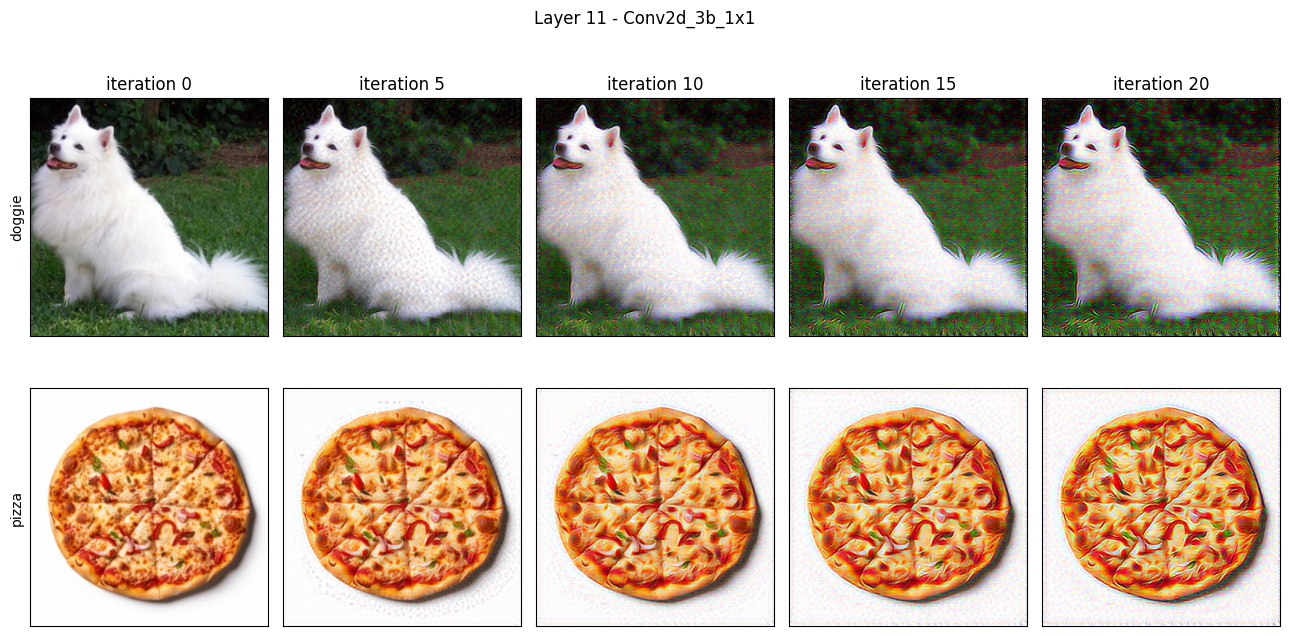

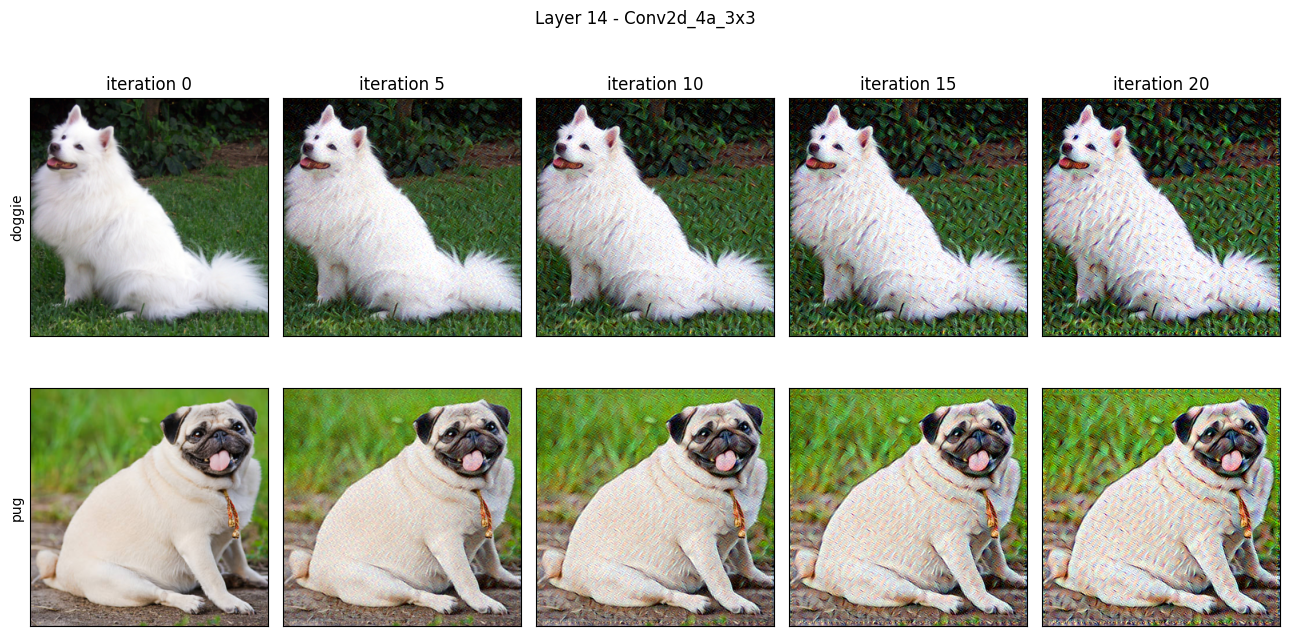

In [ ]:
# Get images
mountain_url = "https://p.turbosquid.com/ts-thumb/fe/3EpLlf/wvg0RHEw/snowmountainprimary01/jpg/1393965432/300x300/sharp_fit_q85/81fd18aacd19ae2e2efdc51dc3de40f5e8f95034/snowmountainprimary01.jpg"
doggie_url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
pug_url = "https://media.istockphoto.com/id/185094249/photo/little-fat-pug-sitting-on-sidewalk-in-summer-park.jpg?s=612x612&w=0&k=20&c=vfvypCBLX7OrPFEM58QLGBd9cuhTEN0SET55z3P31Wo="
pizza_url = "https://thumbs.dreamstime.com/b/high-resolution-pizza-image-white-background-sliced-pepperoni-pizza-toppings-captured-timeless-artistry-style-287201104.jpg"

doggie: torch.Tensor = load_image(doggie_url).unsqueeze(0)
pug: torch.Tensor = load_image(pug_url).unsqueeze(0)
pizza: torch.Tensor = load_image(pizza_url).unsqueeze(0)
mountain: torch.Tensor = load_image(mountain_url).unsqueeze(0)

# Get module names
module_list = Deepdream.get_module_names()

# Choose target layers
layer_11 = [module_list[11]]  # Layer 11 - Conv2d_3b_1x1
layer_14 = [module_list[14]]  # Layer 14 - Conv2d_4a_3x3

# Create Deepdream instances
deepdream11 = Deepdream(layer_11, 20, 4e-02)
deepdream14 = Deepdream(layer_14, 20, 4e-02)

# Generate and display modified images
dream11 = deepdream11.deepdream(torch.cat((doggie, pizza), 0), True)
dream14 = deepdream14.deepdream(torch.cat((doggie, pug), 0), True)

# Plots
plot_iteration_grid(dream11, 5, ["doggie", "pizza"], title="Layer 11 - Conv2d_3b_1x1")
plot_iteration_grid(dream14, 5, ["doggie", "pug"], title="Layer 14 - Conv2d_4a_3x3")

#### Disscusion on 3
The figures above show the effect of two layers on 3 images, over optimization steps. I picked pizza and pug as they were data labels. The impact of optimazation steps is to strengthen the activations of that layer, i.e. increase layer features. Impact of layers is as follows:  
**Layer 11** - Objects are being seperated into "blurry shapes" as optimization steps increase. The fur of the dog becomes a blurry blob of white, but the dog-backgroud border and grass-ground border remain clear. The pizza slices are similar - borders between slices remain sharp as the rest is blurred. As this is an early layer in the net, we can hypothesize that its rule it to disect the image into broad shapes.  
**Layer 14** - Opposed to Layer 11, here the fur and lines of the dogs become sharper as the optimaziation step increases, indicating that this layer detects details inside the broad shapes detected earlier. Moreover, the face of the white dog remains sharper than the rest, so the layer might "recognize" it. Also note that the border of the images is emphasized, might be due to padding.

#### Examples of 4

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


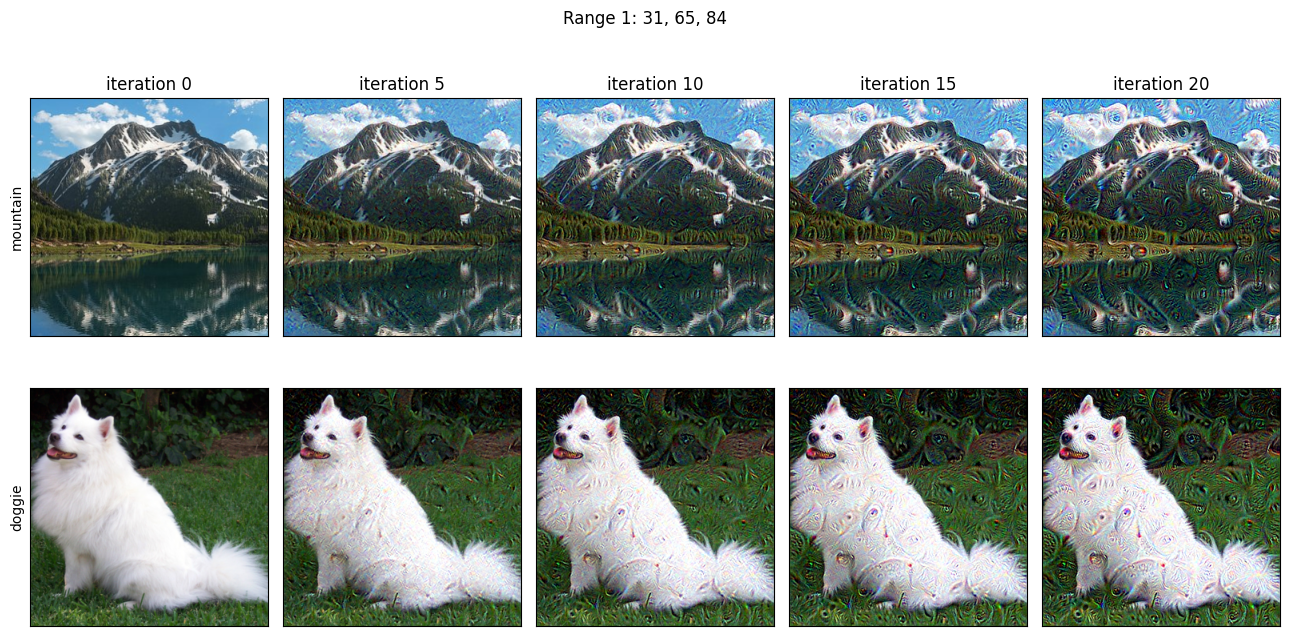

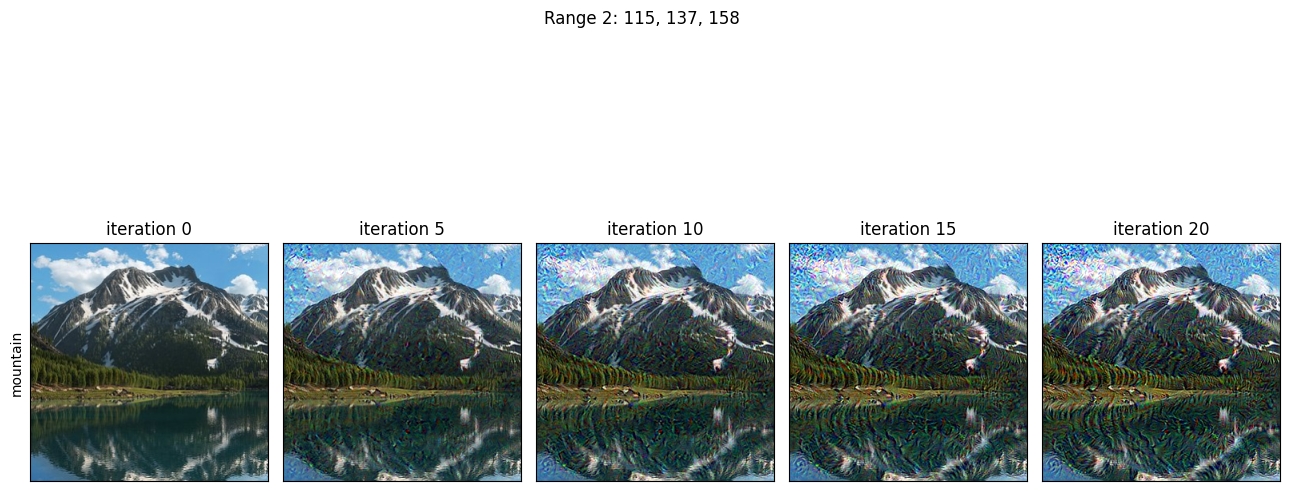

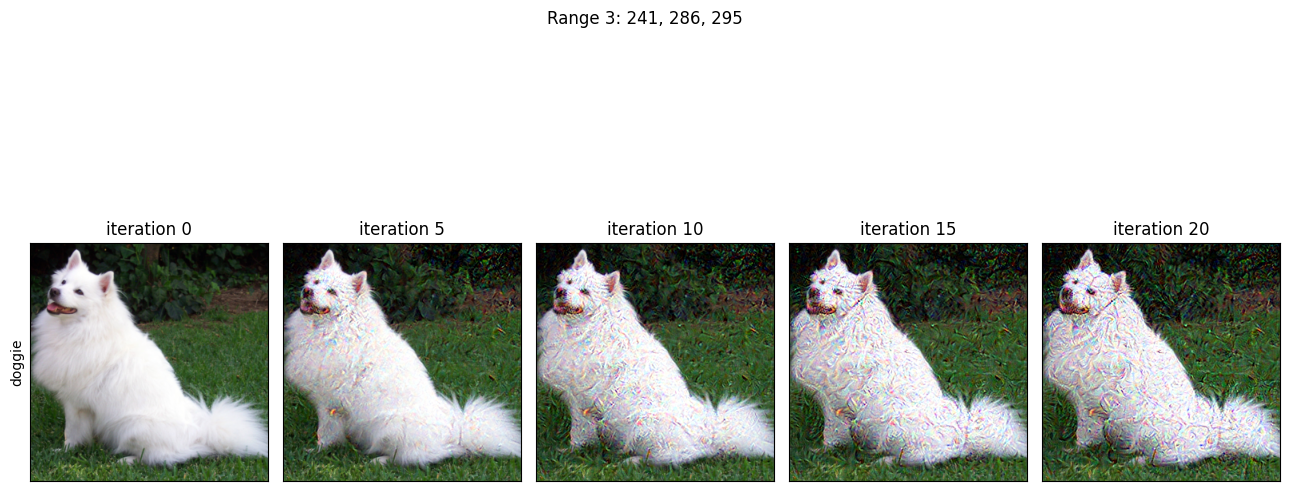

In [ ]:
# Get images
mountain_url = "https://p.turbosquid.com/ts-thumb/fe/3EpLlf/wvg0RHEw/snowmountainprimary01/jpg/1393965432/300x300/sharp_fit_q85/81fd18aacd19ae2e2efdc51dc3de40f5e8f95034/snowmountainprimary01.jpg"
doggie_url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
pug_url = "https://media.istockphoto.com/id/185094249/photo/little-fat-pug-sitting-on-sidewalk-in-summer-park.jpg?s=612x612&w=0&k=20&c=vfvypCBLX7OrPFEM58QLGBd9cuhTEN0SET55z3P31Wo="
pizza_url = "https://thumbs.dreamstime.com/b/high-resolution-pizza-image-white-background-sliced-pepperoni-pizza-toppings-captured-timeless-artistry-style-287201104.jpg"

doggie: torch.Tensor = load_image(doggie_url).unsqueeze(0)
pug: torch.Tensor = load_image(pug_url).unsqueeze(0)
pizza: torch.Tensor = load_image(pizza_url).unsqueeze(0)
mountain: torch.Tensor = load_image(mountain_url).unsqueeze(0)

# Get module names
module_list = Deepdream.get_module_names()

# Choose target layers
comb1 = [module_list[50], module_list[65], module_list[31], module_list[84]]
comb2 = [module_list[137], module_list[158], module_list[115]]
comb3 = [module_list[241], module_list[286], module_list[295]]

# Create Deepdream instances
deepdream1 = Deepdream(comb1, 20, 5e-02)
deepdream2 = Deepdream(comb2, 20, 5e-02)
deepdream3 = Deepdream(comb3, 20, 5e-02)

# Generate and display modified images
dream1 = deepdream1.deepdream(torch.cat((mountain.clone(), doggie.clone()), 0), True)
dream2 = deepdream2.deepdream(mountain.clone(), True)
dream3 = deepdream3.deepdream(doggie.clone(), True)

# Plots
plot_iteration_grid(dream1, 5, ["mountain", "doggie"], title="Range 1: 31, 65, 84")
plot_iteration_grid(dream2, 5, ["mountain"], title="Range 2: 115, 137, 158 ")
plot_iteration_grid(dream3, 5, ["doggie"], title="Range 3: 241, 286, 295")

#### Discussion of 4
The network, with ~300 layers, was analyzed in three ranges: 1-100, 100-200, and 200-300. In the initial range, dream images showed natural phenomena like eyes and paintings ("starry night" style). However, as the range increased, the images became more noisy, suggesting that the information in later layers is deeply processed and as a result lost resemblence to the visual encoding in the first layers.








# Refrences

[1] Keles, F. D., Wijewardena, P. M., & Hegde, C. (2022). On The Computational Complexity of Self-Attention (Version 1). arXiv. http://doi.org/10.48550/ARXIV.2209.04881

[2] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising Diffusion Probabilistic Models (Version 2). arXiv. http://doi.org/10.48550/ARXIV.2006.11239

[3] Saeed, M. (2023).  A Gentle Introduction to Positional Encoding in Transformer Models, Part 1 - MachineLearningMastery.com. Retrieved from https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/